In [1]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install floodlight

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from floodlight.vis.pitches import plot_handball_pitch
from floodlight.core.xy import XY
from floodlight.core.pitch import Pitch
from floodlight.vis.positions import plot_positions
import math
import datetime
from matplotlib.lines import Line2D
from matplotlib.patches import Arc
np.random.seed(31415)

In [2]:
## Import game list and shot list
path_games = '/work/users/ca439qyki/R/Kinexon/Data/Goals/'
game_list_df = pd.read_csv('{path}{filename}'.format(path=path_games, filename='game_list.csv'))
shot_list_df = pd.read_csv('{path}{filename}'.format(path=path_games, filename='shot_list.csv'))
display(shot_list_df)
## only get matches with available positional data
# teams = ['SC DHFK Leipzig', 'MT Melsungen', 'Bergischer HC']
teams = ['SC DHFK Leipzig','Bergischer HC']
game_list_df = game_list_df[game_list_df['home_team'].isin(teams) & game_list_df['away_team'].isin(teams)]

## drop unused columns and not filled rows
game_list_df = game_list_df.drop(game_list_df.columns[0], axis=1)
shot_list_df = shot_list_df[((shot_list_df['game_clock']!='30:00') &(shot_list_df['validated'] != 0))] ## drop all shots from the halftime
shot_list_df = shot_list_df[shot_list_df['game_clock'].notna()] # drop all shot pre game

## add columns to connect shots to kinexon data before splitting it up per game
shot_list_df['timestamp_dt'] = pd.to_datetime(shot_list_df['timestamp'])
shot_list_df['merge_time_shots'] = shot_list_df['timestamp_dt'].apply(lambda x: int(x.value / 1000000))
## Games in Season 2019-2020 does not have a match_id => fill this match id with the match id from the gamelist
shot_list_df.loc[(shot_list_df['match_id'].isna() & shot_list_df['team'].isin(teams) & shot_list_df['timestamp_dt'].dt.date.isin(pd.to_datetime(game_list_df['date']).dt.date)), 'match_id'] = 18949282
shot_list_df = shot_list_df[shot_list_df['team'].isin(teams) & shot_list_df['match_id'].isin(game_list_df['match_id'])]

## add shots per game to the shot row in the dataframe
game_list_df['shots'] = game_list_df['match_id'].apply(lambda x: shot_list_df[shot_list_df['match_id'] == x])

## Set import paths for the kiexon data per game
kinexon_inertial_path = '/work/users/ca439qyki/R/Kinexon/Data/RAW/{short}/Saison_{season}/Spieltag/{gameday_number:02d}/{team_name_home}_vs._{team_name_away}_Match_inertial.csv'
kinexon_positions_path = '/work/users/ca439qyki/R/Kinexon/Data/RAW/{short}/Saison_{season}/Spieltag/{gameday_number:02d}/{team_name_home}_vs._{team_name_away}_Match_positions.csv'

## define starting timestamps for the games
## match id : unix timestamp
starting_times = {18949282: 1569517200000, 23400793: 1613314800000,27373216: 1622988000000,28449996: 1635611400000, 28450398:1653220800000}

PermissionError: [Errno 13] Permission denied: '/work/users/ca439qyki/R/Kinexon/Data/Goals/game_list.csv'

In [3]:
display(game_list_df)

,match_id,date,game_day,home_team,away_team,saison,shots
24,18949282,2019-09-26,7,SC DHFK Leipzig,Bergischer HC,2019_2020,Unnamed: 0 player_id timesta...
148,23400793,2021-02-14,18,Bergischer HC,SC DHFK Leipzig,2020_2021,Unnamed: 0 player_id timesta...
212,27373216,2021-06-06,27,SC DHFK Leipzig,Bergischer HC,2020_2021,Unnamed: 0 player_id timest...
261,28449996,2021-10-30,9,Bergischer HC,SC DHFK Leipzig,2021_2022,Unnamed: 0 player_id timest...
346,28450398,2022-05-22,31,SC DHFK Leipzig,Bergischer HC,2021_2022,Unnamed: 0 player_id timest...


In [4]:
shot_list_game = pd.DataFrame(shot_list_df[(shot_list_df['match_id'] == 23400793)])
shot_list_game

,Unnamed: 0,player_id,timestamp,success,hit_position_z,hit_position_y,shot_position_y,shot_position_x,distance,speed_ball,...,goalkeeper_league_id,action_id,team,last_group,event,updated_at,team_id,match_id,timestamp_dt,merge_time_shots
7901,7902,264,2021-02-14 16:36:44,0,0.103399,4.951591,4.576629,-0.107433,20.621696,35.940018,...,NaN,NaN,Bergischer HC,1,shot,1613363020348,6268,23400793.0,2021-02-14 16:36:44,1613320604000
7902,7903,835,2021-02-14 16:35:38,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Bergischer HC,1,shot,1613363020348,6268,23400793.0,2021-02-14 16:35:38,1613320538000
7904,7905,261,2021-02-14 16:30:42,1,1.020303,0.837790,3.832997,-15.572920,5.855844,9.052303,...,925204.0,NaN,Bergischer HC,1,shot,1613363020348,6268,23400793.0,2021-02-14 16:30:42,1613320242000
7905,7906,140,2021-02-14 16:30:28,1,1.923544,-0.716307,-1.764249,13.835907,6.411601,24.873814,...,124259.0,NaN,SC DHFK Leipzig,2,shot,1613363020348,7962,23400793.0,2021-02-14 16:30:28,1613320228000
7907,7908,252,2021-02-14 16:29:21,1,0.010060,-1.113454,2.365381,-10.957360,9.346890,34.234493,...,925204.0,NaN,Bergischer HC,1,shot,1613363020348,6268,23400793.0,2021-02-14 16:29:21,1613320161000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8050,8051,263,2021-02-14 15:04:08,1,1.486402,-1.236148,-3.065735,14.236115,6.528484,27.668783,...,1315846.0,NaN,Bergischer HC,1,shot,1613363020348,6268,23400793.0,2021-02-14 15:04:08,1613315048000
8051,8052,263,2021-02-14 15:03:09,1,1.577250,-1.439848,-5.577024,14.522816,7.816825,28.635614,...,1315846.0,NaN,Bergischer HC,1,shot,1613363020348,6268,23400793.0,2021-02-14 15:03:09,1613314989000
8053,8054,265,2021-02-14 15:02:11,1,0.946913,-0.910709,-0.155095,14.485455,5.516726,19.803045,...,1315846.0,NaN,Bergischer HC,1,shot,1613363020348,6268,23400793.0,2021-02-14 15:02:11,1613314931000
8054,8055,161,2021-02-14 15:01:28,0,0.719657,1.002847,2.346085,-10.584952,9.702950,30.165503,...,317365.0,NaN,SC DHFK Leipzig,2,shot,1613363020348,7962,23400793.0,2021-02-14 15:01:28,1613314888000


In [12]:
## define utils functions
def calc_game_score(home, success, score_home= 0, score_away= 0):
    if success:
        if home:
            score_home += 1
        else:
            score_away += 1
    return score_home, score_away

def standarderize_coordiates(home, halftime, x, y, saison):
    if saison != '2020_2021':
        if not halftime:
            if home:
                return x, y
            else: 
                return x*(-1), y*(-1)
        else:
            if home:
                return x*(-1), y*(-1)
            else:
                return x, y
    else:
        if not halftime:
            if home:
                return x*(-1), y*(-1)
            else: 
                return x, y
        else:
            if home:
                return x, y
            else:
                return x*(-1), y*(-1)

def calculate_angle_to_mid(x, y):
    S = np.array([x, y])
    Mid = np.array([-20, 0])
    MidS = np.array([x, 0])
    d_v = math.dist(S, Mid) 
    d_w = math.dist(MidS, Mid)
    v = S - Mid
    w = MidS - Mid
    return np.arccos(np.dot(v,w)/(d_v * d_w))

def calculate_angle_from_shooter_to_gk(x_Shot, y_Shot, x_gk, y_gk):
    S = np.array([x_Shot, y_Shot])
    if x_gk < 0:
        Mid = np.array([-20, 0])
    else:
        Mid = np.array([20, 0])
    MidS = np.array([x_gk, y_gk])
    d_v = math.dist(S, Mid) 
    d_w = math.dist(MidS, Mid)
    v = S - Mid
    w = MidS - Mid
    return np.arccos(np.dot(v,w)/(d_v * d_w))

def calculate_visible_angle(x,y):
    S = np.array([x, y])
    G1 = np.array([-20,-1.5])
    G2 = np.array([-20, 1.5])
    d_v = math.dist(S, G1)
    d_w = math.dist(S, G2)
    v = G1 - S
    w = G2 - S
    return np.arccos(np.dot(v,w)/(d_v * d_w))

def calculate_distance(x1,y1, x2, y2):
    P1 = np.array([x1, y1])
    P2 = np.array([x2, y2])
    return math.dist(P1, P2)

def round_to_next_n(x, n=50):
    return int(n * round(float(x)/n))

def players_in_shot_angle(x_shot, y_shot, home, halftime, pos_x_list, pos_y_list, saison):
    if saison != '2020_2021':
        if ((home) and (not halftime)) or ((not home) and (halftime)):
            polygon = Polygon([(x_shot, y_shot), (-20, -1.50), (-20, 1.50)])
        else:
            polygon = Polygon([(x_shot, y_shot), (20, -1.50), (20, 1.50)])
    else:
        if ((home) and (not halftime)) or ((not home) and (halftime)):
            polygon = Polygon([(x_shot, y_shot), (20, -1.50), (20, 1.50)])
        else:
            polygon = Polygon([(x_shot, y_shot), (-20, -1.50), (-20, 1.50)])
    
    i = 0
    for pos_x, pos_y in zip(pos_x_list, pos_y_list):
        point = Point(pos_x, pos_y)
        i += polygon.contains(point)    
        
    return i

func_round = np.vectorize(round_to_next_n)
func_coord = np.vectorize(standarderize_coordiates)
func_visible_angle = np.vectorize(calculate_visible_angle)
func_angle_to_mid = np.vectorize(calculate_angle_to_mid)
func_game_score = np.vectorize(calc_game_score)
func_angle_shooter_gk = np.vectorize(calculate_angle_from_shooter_to_gk)
func_dist = np.vectorize(calculate_distance)

# plot handball pitch
def plot_positions_on_pitch(home_data, away_data, shot_event, shooter_snapshot,i, type=''):
    colors = ['green', 'blue', 'red']
    events = [['SC DHFK Leipzig'], ['Bergischer HC'], ['Ball']]
    #plot player and ball positions on the pitch
    ax = plt.subplots(figsize=(10, 5))[1]
    plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=True, ax=ax)
    for color, event in zip(colors, events):
        alphas = [1]
        if color == 'blue':
            x_list = list(home_data.loc[home_data['group name'] != 'Ball']['x in m'])
            y_list = list(home_data.loc[home_data['group name'] != 'Ball']['y in m'])
            if len(x_list) > 20:
                alphas = [x/len(x_list)*0.5 for x in range(1,len(x_list))]
        if color == 'yellow':
            x_list = list(home_data.loc[home_data['group name'] == 'Ball']['x in m'])
            y_list = list(home_data.loc[home_data['group name'] == 'Ball']['y in m'])
            if len(x_list) > 20:
                alphas = [x/len(x_list)*0.5 for x in range(1,len(x_list))]
        if color == 'green':
            x_list = list(away_data['x in m'])
            y_list = list(away_data['y in m'])
            if len(x_list) > 20:
                alphas = [x/len(x_list)*0.5 for x in range(1,len(x_list))]
        if color == 'red':
            x_list = [shot_event['shot_position_x']]
            # y_list = [shot['shot_position_y']]
            y_list = [-shot_event['shot_position_y']]
        xy_pos = np.array([[coord for coords in zip(x_list, y_list) for coord in coords]])
        plot_positions(xy=XY(xy_pos), ball=False, ax=ax, frame=0, color=color, label=event[0], alpha = alphas)
    
    # plot lines to the goalposts
    if row['saison'] != '2020_2021':
        if ((shot['home']) and (not shot['halftime'])) or ((not shot['home']) and (shot['halftime'])):
            ax.plot([shooter_snapshot['x in m'].values[0], -20], [shooter_snapshot['y in m'].values[0],-1.5], linewidth=1, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
            ax.plot([shooter_snapshot['x in m'].values[0], -20], [shooter_snapshot['y in m'].values[0],1.5], linewidth=1, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
            # ax.plot([shot['shot_position_x'], -20], [-shot['shot_position_y'],-1.55], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
            # ax.plot([shot['shot_position_x'], -20], [-shot['shot_position_y'],1.55], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
        else:
            if ((not shot['home']) and (not shot['halftime'])) or ((shot['home']) and (shot['halftime'])):
                # ax.plot([shot['shot_position_x'], 20], [-shot['shot_position_y'],-1.55], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
                # ax.plot([shot['shot_position_x'], 20], [-shot['shot_position_y'],1.55], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
                ax.plot([shooter_snapshot['x in m'].values[0], 20], [shooter_snapshot['y in m'].values[0],-1.5], linewidth=1, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
                ax.plot([shooter_snapshot['x in m'].values[0], 20], [shooter_snapshot['y in m'].values[0],1.5], linewidth=1, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
    else:
        if ((shot['home']) and (not shot['halftime'])) or ((not shot['home']) and (shot['halftime'])):
            ax.plot([shooter_snapshot['x in m'].values[0], 20], [shooter_snapshot['y in m'].values[0],-1.5], linewidth=1, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
            ax.plot([shooter_snapshot['x in m'].values[0], 20], [shooter_snapshot['y in m'].values[0],1.5], linewidth=1, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
            # ax.plot([shot['shot_position_x'], -20], [-shot['shot_position_y'],-1.55], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
            # ax.plot([shot['shot_position_x'], -20], [-shot['shot_position_y'],1.55], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
        else:
            if ((not shot['home']) and (not shot['halftime'])) or ((shot['home']) and (shot['halftime'])):
                # ax.plot([shot['shot_position_x'], 20], [-shot['shot_position_y'],-1.55], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
                # ax.plot([shot['shot_position_x'], 20], [-shot['shot_position_y'],1.55], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
                ax.plot([shooter_snapshot['x in m'].values[0], -20], [shooter_snapshot['y in m'].values[0],-1.5], linewidth=1, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
                ax.plot([shooter_snapshot['x in m'].values[0], -20], [shooter_snapshot['y in m'].values[0],1.5], linewidth=1, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
                       
    leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    for l in leg.legendHandles:
        l.set_alpha(1)
    # plt.show()
    plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/Visualize_Positions_{}_{}.png".format(i, type), bbox_inches="tight")
    
def get_angle_plot(line1, line2, offset = 1, color = None, origin = [-20,0], len_x_axis = 3, len_y_axis = 3):
    if origin == [-20,0]:
        thetaoffset = 0
    else:
        thetaoffset = -180
    l1xy = line1.get_xydata()

    # Angle between line1 and x-axis
    slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
    # angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle
    angle1 = math.degrees(math.atan(slope1))

    l2xy = line2.get_xydata()

    # Angle between line2 and x-axis
    slope2 = (l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
    # angle2 = abs(math.degrees(math.atan(slope2)))
    angle2 = math.degrees(math.atan(slope2))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.

    return Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1+thetaoffset , theta2+thetaoffset, color=color, label = str(angle)+u"\u00b0")

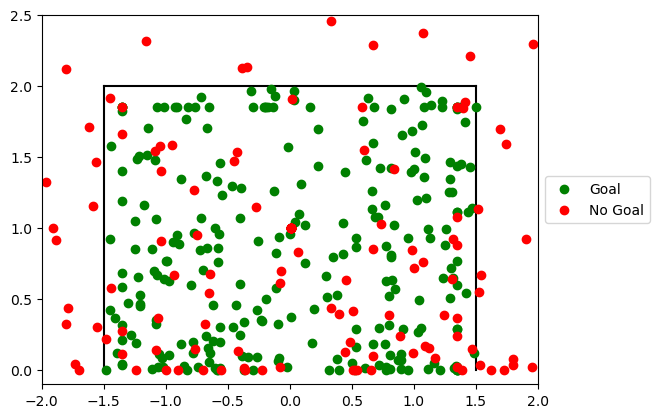

In [6]:
# plot handball goal
colors = ['green', 'red']
events = [('Goal',1), ('No Goal', 0)]

def print_Goal(ax):
    ax.plot([-1.5,-1.5], [0, 2], linewidth=1.5, color="Black",zorder=0, alpha = 1) #left
    ax.plot([-1.5, 1.5], [2, 2], linewidth=1.5, color="Black",zorder=0, alpha = 1) #Top
    ax.plot([1.5,1.5], [0, 2], linewidth=1.5, color="Black",zorder=0, alpha = 1) #Right

ax = plt.subplots()[1]
print_Goal(ax)
for color, event in zip(colors, events):
    x_list = list(shot_list_df.loc[shot_list_df['success'] == event[1]]['hit_position_y'])
    y_list = list(shot_list_df.loc[shot_list_df['success'] == event[1]]['hit_position_z'])
    ax.scatter(x_list, y_list, label=event[0], c=color)
    # ax.scatter( y_list, x_list,label=event[0], c=color)
plt.legend(numpoints=1)
plt.xlim(-2, 2);
plt.ylim(-0.1, 2.5);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

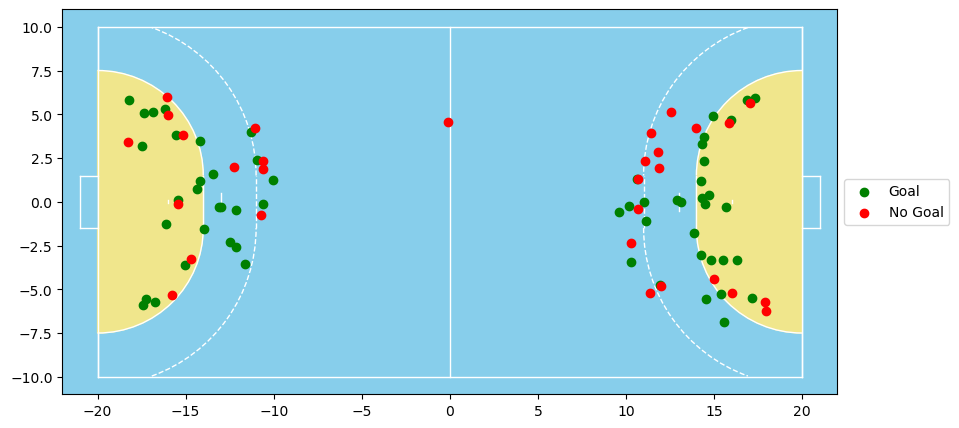

In [7]:
# plot handball pitch
colors = ['green', 'red']
events = [('Goal',1), ('No Goal', 0)]
row = game_list_df[game_list_df['match_id']==23400793]
shot_list_game['halftime'] = pd.to_timedelta(['00:'+time for time in shot_list_game['game_clock']]) > datetime.timedelta(minutes=30)
shot_list_game['home'] = shot_list_game['team'].isin([row['home_team']])
shot_list_game['norm_x_shot'], shot_list_game['norm_y_shot'] = func_coord(shot_list_game['home'], shot_list_game['halftime'], shot_list_game['shot_position_x'], shot_list_game['shot_position_y'], row['saison'])
    

ax = plt.subplots(figsize=(10, 5))[1]
plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='standard',show_axis_ticks=True, ax=ax)
for color, event in zip(colors, events):
    x_list = list(shot_list_game.loc[shot_list_game['success'] == event[1]]['shot_position_x'])
    y_list = list(shot_list_game.loc[shot_list_game['success'] == event[1]]['shot_position_y'])
    xy_pos = np.array([[coord for coords in zip(x_list, y_list) for coord in coords]])
    plot_positions(xy=XY(xy_pos), ball=False, ax=ax, frame=0, color=color, label=event[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

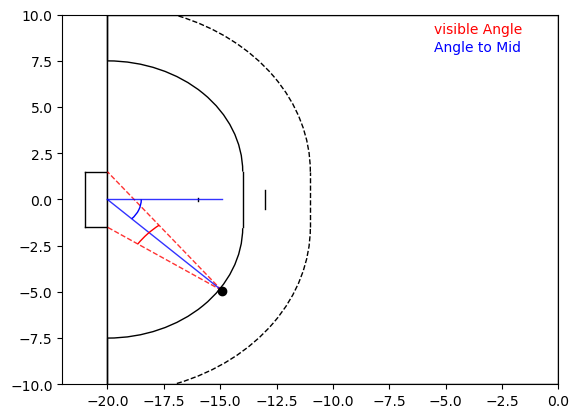

In [9]:
## Visualize 1 shot
one_shot = shot_list_game[(shot_list_game['Unnamed: 0']==7933) | (shot_list_game['Unnamed: 0']==7930)]

## plot pitch
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=True, ax=ax)

##plot shot position
x_list = list(one_shot['norm_x_shot'])
y_list = list(one_shot['norm_y_shot'])
xy_pos = np.array([[coord for coords in zip(x_list, y_list) for coord in coords]])
plot_positions(xy=XY(xy_pos), ball=False, ax=ax, frame=0)
line_1 = Line2D([x_list[0], -20], [y_list[0],-1.50], linewidth=1, linestyle = "--", color="red", zorder=0, alpha = 0.8)
line_2 = Line2D([x_list[0], -20], [y_list[0],1.50], linewidth=1, linestyle = "--", color="red", zorder=0, alpha = 0.8)
## plot line from shot position to goal posts (visible angle of the goal)
ax.add_line(line_1)
ax.add_line(line_2)
angle_plot = get_angle_plot(line_1, line_2, origin=(x_list[0],y_list[0]), offset=3)
ax.add_patch(angle_plot) # To display the angle arc

## plot distance to mid
line_1 = Line2D([x_list[0], -20], [y_list[0],0], linewidth=1, linestyle = "-", color="blue", zorder=0, alpha = 0.8)
line_2 = Line2D([x_list[0], -20],  [0,0], linewidth=1, linestyle = "-", color="blue", zorder=0, alpha = 0.8)
angle_plot = get_angle_plot(line_1, line_2, 1, origin=[-20,0])
ax.add_line(line_1)
ax.add_line(line_2)
ax.add_patch(angle_plot) # To display the angle arc
ax.text(-5.5, 9, "visible Angle", color="red")
ax.text(-5.5, 8, "Angle to Mid", color="blue")
plt.ylim(-10, 10)
plt.xlim(-22, 0)
# plt.show()
plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/Angle_Explanation.png")

,ts in ms,sensor id,x in m,y in m,z in m,merge_time
0,1635611165146,45243,-9.598,-3.899,1.6,1635611165150
1,1635611165212,45243,-9.388,-3.759,1.6,1635611165200
2,1635611165278,45243,-9.176,-3.625,1.6,1635611165300


,ts in ms,sensor id,mapped id,number,full name,group name,speed in m/s,direction of movement in deg,acceleration in m/s2,ball possession (id of possessed ball),merge_time
16716,1635611320600,45201,261,21,Sebastian Damm,Bergischer HC,2.652,95.382,-0.285,NaN,1635611320600
430499,1635613729300,45204,252,22,Fabian Gutbrod,Bergischer HC,0.000,NaN,0.000,NaN,1635613729300
968528,1635617014300,45199,267,9,Alexander Weck,Bergischer HC,0.211,NaN,0.176,NaN,1635617014300


,match_id,date,game_day,home_team,away_team,saison,shots
24,18949282,2019-09-26,7,SC DHFK Leipzig,Bergischer HC,2019_2020,Unnamed: 0 player_id timesta...
148,23400793,2021-02-14,18,Bergischer HC,SC DHFK Leipzig,2020_2021,Unnamed: 0 player_id timesta...
212,27373216,2021-06-06,27,SC DHFK Leipzig,Bergischer HC,2020_2021,Unnamed: 0 player_id timest...


,Unnamed: 0,player_id,timestamp,success,hit_position_z,hit_position_y,shot_position_y,shot_position_x,distance,speed_ball,...,event,updated_at,team_id,match_id,timestamp_dt,merge_time_shots,halftime,home,norm_x_shot,norm_y_shot
17508,17509,651,2021-10-30 16:32:42,0,0.546378,1.525957,1.714587,10.600447,9.554654,30.205626,...,shot,1635611581371,7962,28449996.0,2021-10-30 16:32:42,1635611562000,False,False,-10.600447,-1.714587
17509,17510,280,2021-10-30 16:32:49,1,1.100485,0.071086,5.067685,-17.752932,5.543532,23.403137,...,shot,1635611581371,6268,28449996.0,2021-10-30 16:32:49,1635611569000,False,True,-17.752932,5.067685
17510,17511,164,2021-10-30 16:33:32,1,0.051612,1.162671,-0.981290,14.830914,5.261405,21.505232,...,shot,1635611625376,7962,28449996.0,2021-10-30 16:33:32,1635611612000,False,False,-14.830914,0.981290


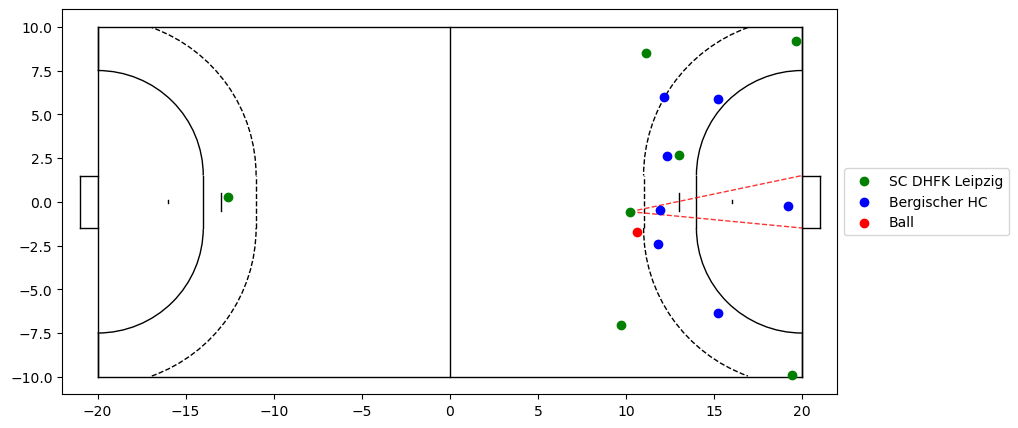

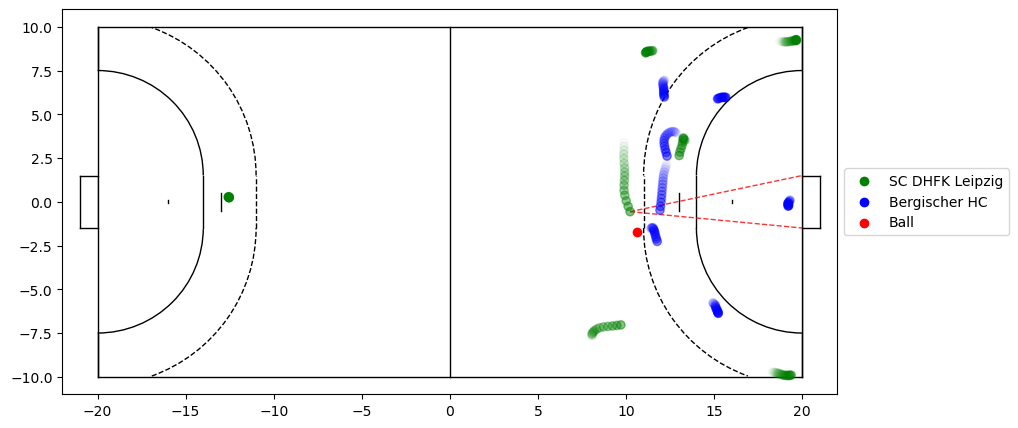

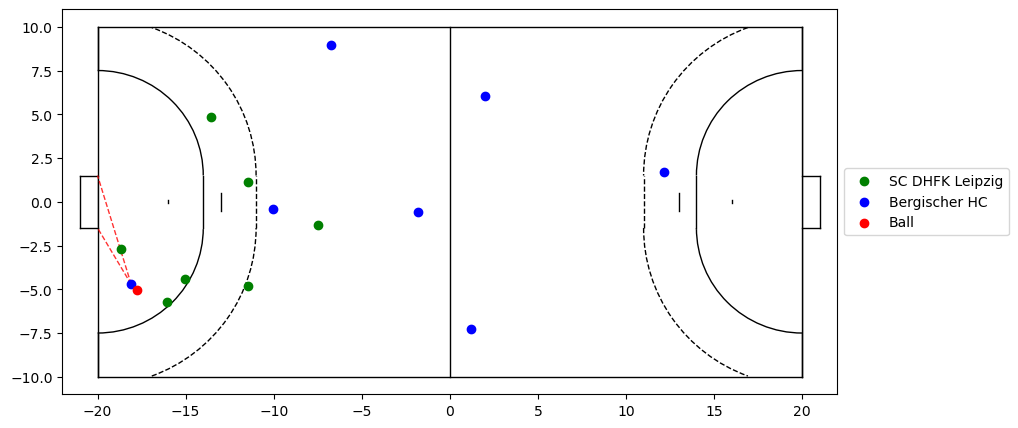

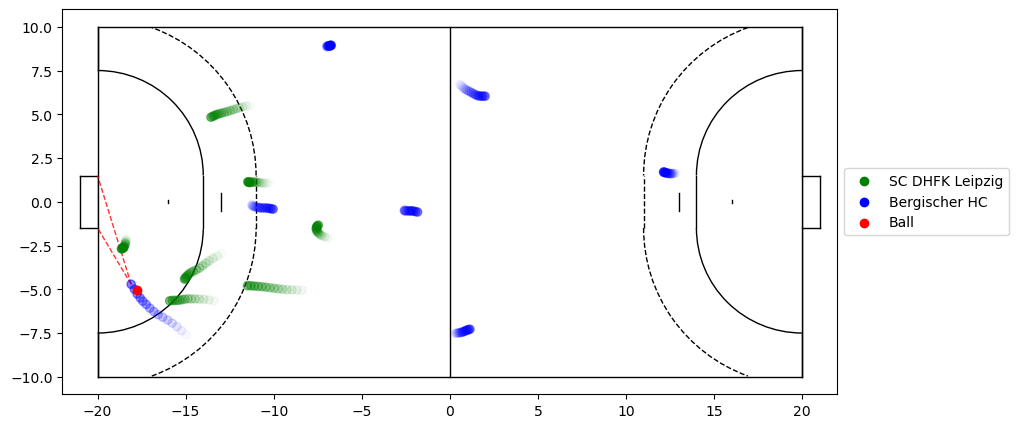

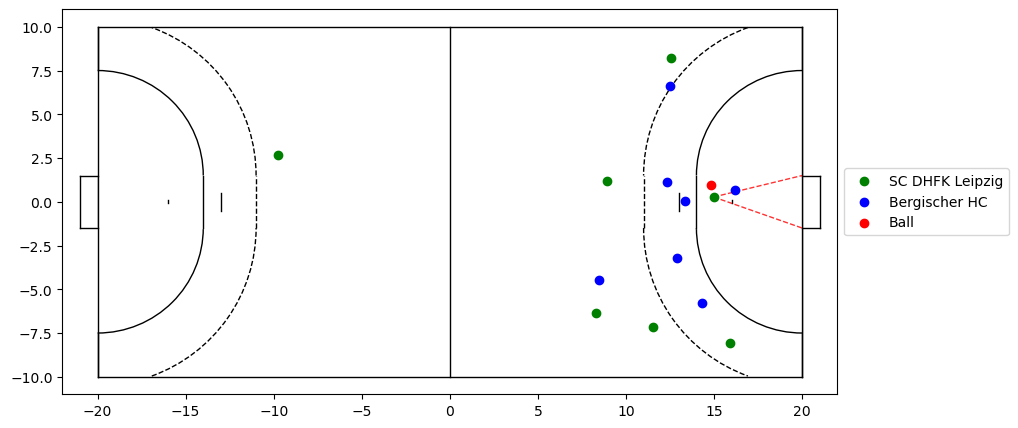

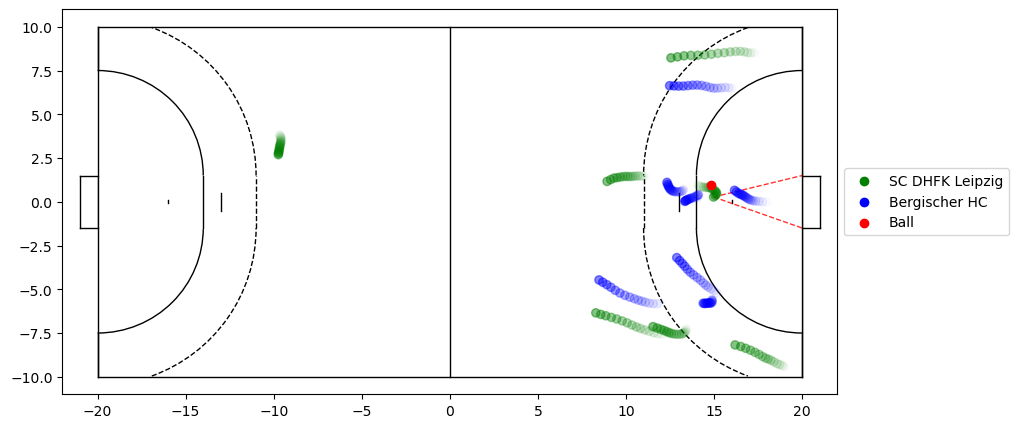

In [13]:
shot_list_df = pd.DataFrame()

player_ids = pd.read_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Data/players_sensors_map.csv', usecols=[1,2,3,4,5])
goalkeepers = player_ids[player_ids['goalie'] == 1]
test = game_list_df[game_list_df['match_id']== 28449996]
for idx, row in test.iterrows():
    if row['saison'] == '2019_2020':
        teams_dict = {'SC DHFK Leipzig':('DHFK', 'SC_DHfK_Leipzig'),'Bergischer HC': ('BHC', 'Bergischer')}
    else:
        teams_dict = {'SC DHFK Leipzig':('DHFK', 'SC_DHfK_Leip'),'Bergischer HC': ('BHC', 'Bergischer_HC')}
    
    ## import relevant Kinexon Data for the Game
    home_team = teams_dict.get(row['home_team'])
    away_team = teams_dict.get(row['away_team'])
    home_inertial_df = pd.read_csv(kinexon_inertial_path.format(short=home_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';', usecols=[0,2,9,10,11])
    home_pos_df = pd.read_csv(kinexon_positions_path.format(short=home_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';',usecols=[0,2,3,4,5,8,9,10,11,16])
    away_inertial_df = pd.read_csv(kinexon_inertial_path.format(short=away_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';', usecols=[0,2,9,10,11])
    away_pos_df = pd.read_csv(kinexon_positions_path.format(short=away_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';', usecols=[0,2,3,4,5,8,9,10,11,16])
    shot_list_game = pd.DataFrame(row['shots'])
    ## merge inertial and pos Dataframes for home and away
    away_inertial_df['merge_time'] = func_round(away_inertial_df['ts in ms'])
    away_pos_df['merge_time'] = away_pos_df['ts in ms']
    home_inertial_df['merge_time'] = func_round(home_inertial_df['ts in ms'])
    home_pos_df['merge_time'] = home_pos_df['ts in ms']
    away_game_data = pd.merge(away_pos_df, away_inertial_df, how='left', on=['merge_time', 'sensor id'], suffixes=(None, '_inertial'))
    home_game_data = pd.merge(home_pos_df, home_inertial_df, how='left', on=['merge_time', 'sensor id'], suffixes=(None, '_inertial'))
    
    ## drop Rows where no x and y coordinates are given in the kinexon datasets
    home_game_data = home_game_data.dropna(subset=['x in m', 'y in m'])
    away_game_data = away_game_data.dropna(subset=['x in m', 'y in m'])
    
    ## Create timestamp for Kinexon-Data in ms to compare it with the shots
    home_game_data['merge_time_shots'] = func_round(home_game_data['ts in ms'], n=1000)
    away_game_data['merge_time_shots'] = func_round(away_game_data['ts in ms'], n=1000)
    ## Create features for each shot
    ## reverse sorting of match 18949282 because the last shot is first in the list
    shot_list_game = pd.DataFrame(row['shots'])
    if (row['match_id'] == 18949282):
        shot_list_game = shot_list_game.iloc[::-1]

    shot_list_game = shot_list_game[shot_list_game['merge_time_shots'] >= starting_times.get(row['match_id'])]
    shot_list_game['halftime'] = pd.to_timedelta(['00:'+time for time in shot_list_game['game_clock']]) > datetime.timedelta(minutes=30)
    shot_list_game['home'] = shot_list_game['team'].isin([row['home_team']])
    shot_list_game['norm_x_shot'], shot_list_game['norm_y_shot'] = func_coord(shot_list_game['home'], shot_list_game['halftime'], shot_list_game['shot_position_x'], shot_list_game['shot_position_y'], row['saison'])
    
    display(away_inertial_df.head(3))
    display(home_pos_df.iloc[[16716,430499,968528]])
    display(game_list_df.head(3))
    display(shot_list_game.head(3))
    i = 0
    for idx, shot in shot_list_game.iterrows():
        ## Get Kinexon-Data for the timestamp of the shot
        shot_away_pos = away_game_data[away_game_data['merge_time_shots'] == shot['merge_time_shots']]
        shot_home_pos = home_game_data[home_game_data['merge_time_shots'] == shot['merge_time_shots']]
        player = player_ids.loc[player_ids['league_id'] == shot['league_id']]['player_id'].values
        
        ## Get Shooter and Goalkeeper Data (position, speed...)
        if shot['home']:
            shooter = shot_home_pos[(shot_home_pos['mapped id'] == player.item())]
            goalkeeper = shot_away_pos.loc[shot_away_pos['mapped id'].isin(goalkeepers['player_id'])]
        else:
            shooter = shot_away_pos[(shot_away_pos['mapped id'] == player.item())]
            goalkeeper = shot_home_pos.loc[shot_home_pos['mapped id'].isin(goalkeepers['player_id'])]
            
        ## Some manual captured shots does not math the kinexon data => Shot will be skipped
        if shooter.empty:
            continue

        ## Get snapshot timestamp to get a frozen frame of all player positions
        snapshot_shot_timestamp = shooter['ts in ms'].iloc[-1]
        
        ## Get player positions to the calculated timestamp
        snapshot_home = shot_home_pos[shot_home_pos['ts in ms'] == snapshot_shot_timestamp]
        snapshot_away = shot_away_pos[shot_away_pos['ts in ms'] == snapshot_shot_timestamp]
        snapshot_goalkeeper = goalkeeper[goalkeeper['ts in ms'] == snapshot_shot_timestamp]
        snapshot_shooter = shooter[shooter['ts in ms'] == snapshot_shot_timestamp]
        ## plot only snapshot position
        plot_positions_on_pitch(snapshot_home, snapshot_away, shot, snapshot_shooter, i,'single')
        ##plot position of the last 1 second
        plot_positions_on_pitch(shot_home_pos, shot_away_pos, shot, snapshot_shooter, i,'movement')
        i+= 1
        if i > 2:
            break;